# Introdução

Este projeto tem como objetivo analisar dados clínicos relacionados à falha cardíaca (heart failure) para identificar padrões que auxiliem na predição do risco de óbito dos pacientes. A falha cardíaca é uma condição grave que afeta a capacidade do coração de bombear sangue adequadamente, e a detecção precoce pode melhorar significativamente o manejo clínico e os resultados para os pacientes. Utilizando técnicas de análise exploratória de dados (EDA) e aprendizado de máquina, buscamos entender as características mais relevantes e construir modelos preditivos eficientes para apoiar decisões médicas.

## Informações do conjunto de dados

1 - Age: idade do paciente [anos]\
2 - Sex: sexo do paciente [M: Masculino, F: Feminino]\
3 - ChestPainType: tipo de dor torácica [TA: Angina típica, ATA: Angina atípica, NAP: Dor não anginosa, ASY: Assintomática]\
4 - ResgingBP: pressão arterial em repouso [mm Hg]\
5- Cholesterol: colesterol sérico [mm/dl]\
6- FastingBS: glicemia em jejum [1: se BS em jejum > 120 mg/dl, 0: caso contrário]\
7 - ResgingECG: resultados do eletrocardiograma em repouso [Normal: Normal, ST: com anormalidade das ondas ST-T (inversões das ondas T e/ou elevação ou depressão de ST > 0,05 mV), HVE: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de testes]\
8 - MaxHR: frequência cardíaca máxima alcançada [valor numérico entre 60 e 202]\
9 - ExercícioAngina: angina induzida por exercício [Y: Sim, N: Não]\
10 - Oldpeak: oldpeak = ST [Valor numérico medido na depressão]\
11 - ST_Slope: a inclinação do segmento ST do pico do exercício [Up: subida, Flat: flat, Down: downsloping]\
12 - HeartDisease: classe de saída [1: doença cardíaca, 0: Normal]\

In [115]:
# Importando os pacotes que serão utilizados

import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import seaborn as sns
from scipy.stats import chi2_contingency,ttest_ind
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format


# Metodologia

Inicialmente, realizamos uma análise exploratória dos dados para verificar distribuições, valores ausentes, outliers e possíveis correlações entre as variáveis clínicas e o desfecho (óbito). Em seguida, aplicamos transformações necessárias, como codificação de variáveis categóricas e normalização, para preparar os dados para modelagem.

Foram treinados diferentes modelos de classificação, incluindo regressão logística, Random Forest e XGBoost, com avaliação utilizando métricas como acurácia, precisão, recall, F1-score e AUC-ROC. Para interpretar os resultados dos modelos, utilizamos a ferramenta SHAP para identificar as variáveis que mais influenciam as predições, permitindo maior transparência e entendimento clínico dos fatores de risco.


In [84]:
# Carregando o arquivo CSV

df = pd.read_csv('/content/heart.csv')

In [85]:
# Verificando as primeiras linhas do DataFrame

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0


In [86]:
# Verificando as dimensões do arquivo.

df.shape

(918, 12)

In [87]:
# Verificando informações do arquivo

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [88]:
# Verificando se há valores nulos (dados missing)

df.isnull().sum()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


In [89]:
# Total de valores únicos de cada variável

valores_unicos = []
for i in df.columns[0:12].tolist():
    print(i, ':', len(df[i].astype(str).value_counts()))
    valores_unicos.append(len(df[i].astype(str).value_counts()))

Age : 50
Sex : 2
ChestPainType : 4
RestingBP : 67
Cholesterol : 222
FastingBS : 2
RestingECG : 3
MaxHR : 119
ExerciseAngina : 2
Oldpeak : 53
ST_Slope : 3
HeartDisease : 2


In [90]:
# Visualizando algumas medidas estatisticas.

df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.00,918.00,918.00,918.00,918.00,918.00,918.00
mean,53.51,132.40,198.80,0.23,136.81,0.89,0.55
std,9.43,18.51,109.38,0.42,25.46,1.07,0.50
min,28.00,0.00,0.00,0.00,60.00,-2.60,0.00
25%,47.00,120.00,173.25,0.00,120.00,0.00,0.00
50%,54.00,130.00,223.00,0.00,138.00,0.60,1.00
75%,60.00,140.00,267.00,0.00,156.00,1.50,1.00
max,77.00,200.00,603.00,1.00,202.00,6.20,1.00


In [91]:
df.duplicated().sum()

np.int64(0)

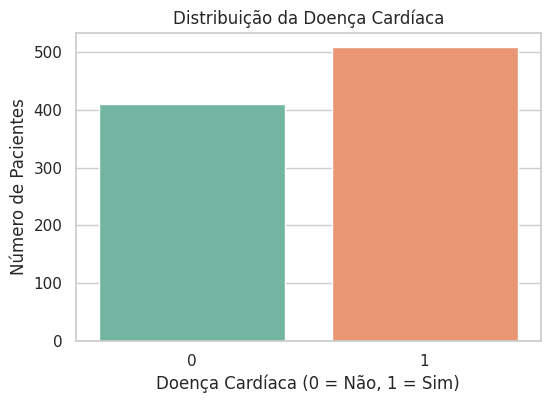

In [92]:
sns.set(style="whitegrid")

# Gráfico de barras da variável alvo
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='HeartDisease', palette='Set2')
plt.title("Distribuição da Doença Cardíaca")
plt.xlabel("Doença Cardíaca (0 = Não, 1 = Sim)")
plt.ylabel("Número de Pacientes")
plt.show()

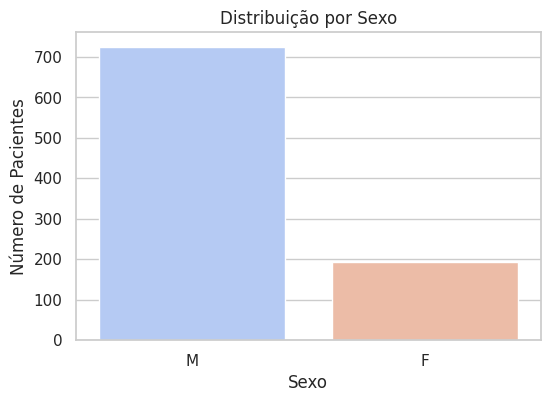

In [93]:
#Gráfico de barra da distribuição da quantidade de pacientes agrupados por sexo
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Sex', palette='coolwarm')
plt.title("Distribuição por Sexo")
plt.xlabel("Sexo")
plt.ylabel("Número de Pacientes")
plt.show()

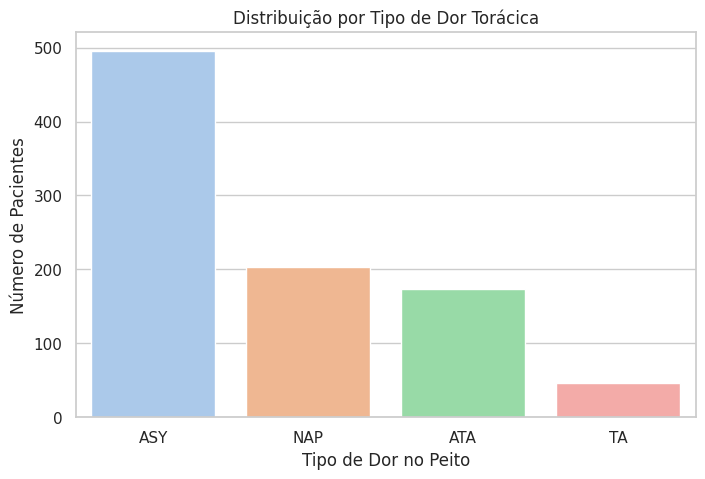

In [94]:
# Gráfico da distribuição da quantidade de pacientes segundo o tipo de dor torácica
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='ChestPainType', palette='pastel', order=df['ChestPainType'].value_counts().index)
plt.title("Distribuição por Tipo de Dor Torácica")
plt.xlabel("Tipo de Dor no Peito")
plt.ylabel("Número de Pacientes")
plt.show()

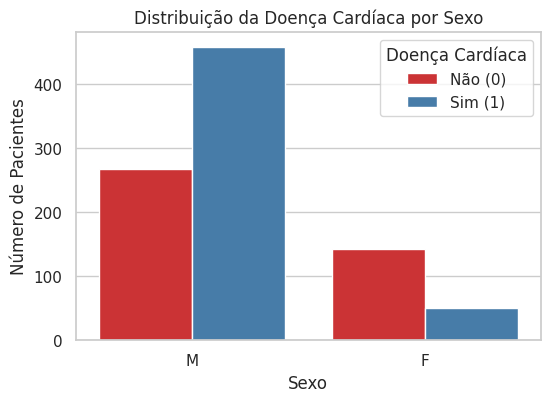

In [95]:
#Gráfico da distribuição da presença de doença cardíaca separada por sexo
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Sex', hue='HeartDisease', palette='Set1')
plt.title("Distribuição da Doença Cardíaca por Sexo")
plt.xlabel("Sexo")
plt.ylabel("Número de Pacientes")
plt.legend(title='Doença Cardíaca', labels=['Não (0)', 'Sim (1)'])
plt.show()

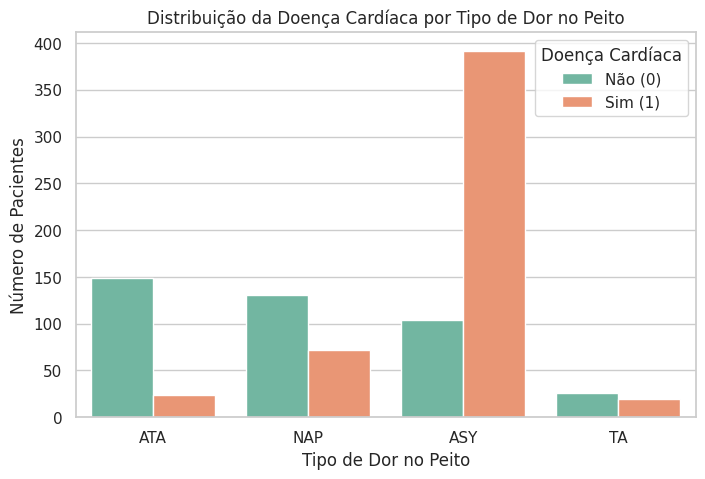

In [96]:
#Gráfico da distribuição da presença de doença cardíaca de acordo com o tipo de dor torácica
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='ChestPainType', hue='HeartDisease', palette='Set2')
plt.title("Distribuição da Doença Cardíaca por Tipo de Dor no Peito")
plt.xlabel("Tipo de Dor no Peito")
plt.ylabel("Número de Pacientes")
plt.legend(title='Doença Cardíaca', labels=['Não (0)', 'Sim (1)'])
plt.show()

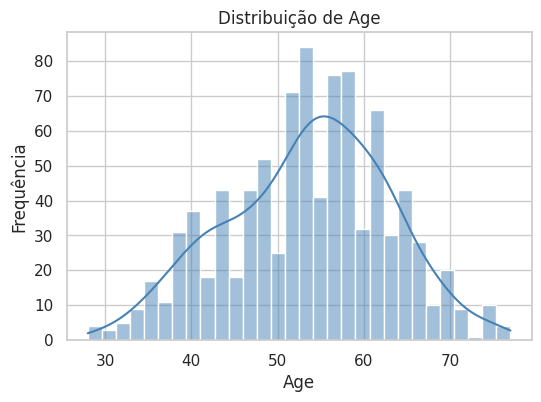

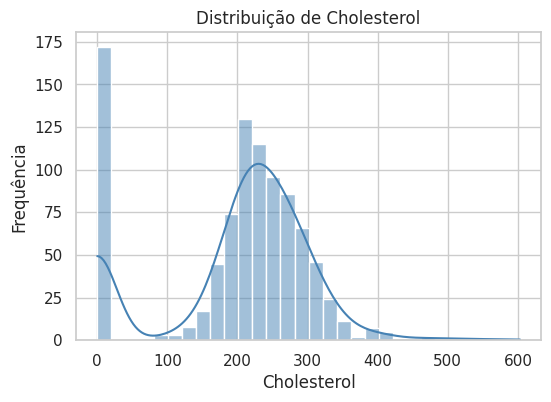

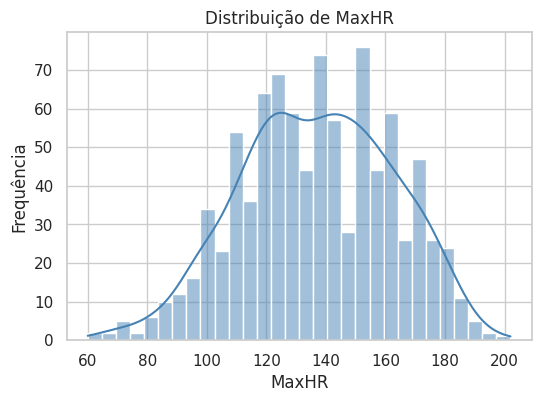

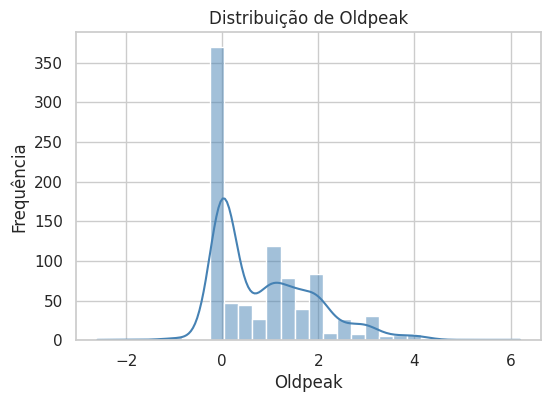

In [97]:
num_cols = ['Age', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Plots
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=col, kde=True, bins=30, color='steelblue')
    plt.title(f'Distribuição de {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.show()

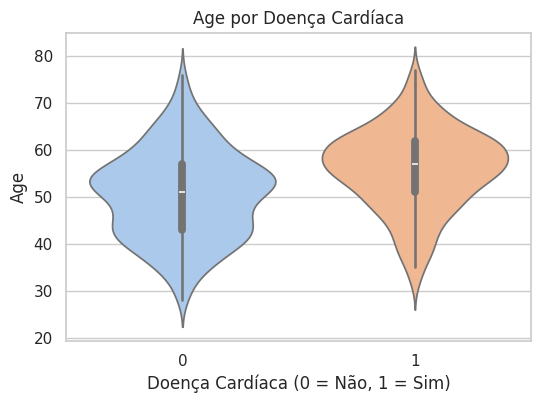

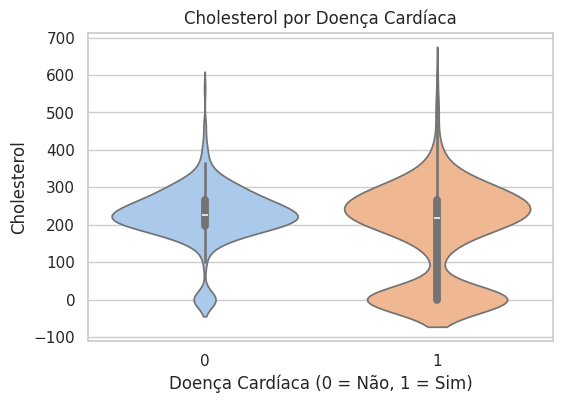

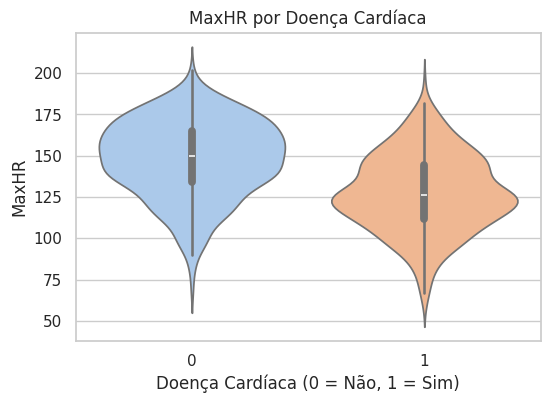

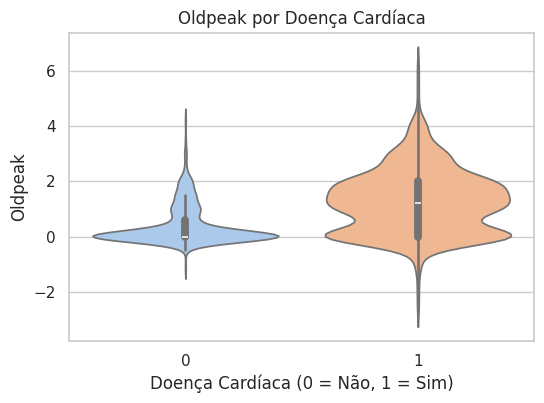

In [98]:
for col in ['Age', 'Cholesterol', 'MaxHR', 'Oldpeak']:
    plt.figure(figsize=(6, 4))
    sns.violinplot(x='HeartDisease', y=col, data=df, palette='pastel')
    plt.title(f'{col} por Doença Cardíaca')
    plt.xlabel('Doença Cardíaca (0 = Não, 1 = Sim)')
    plt.ylabel(col)
    plt.show()

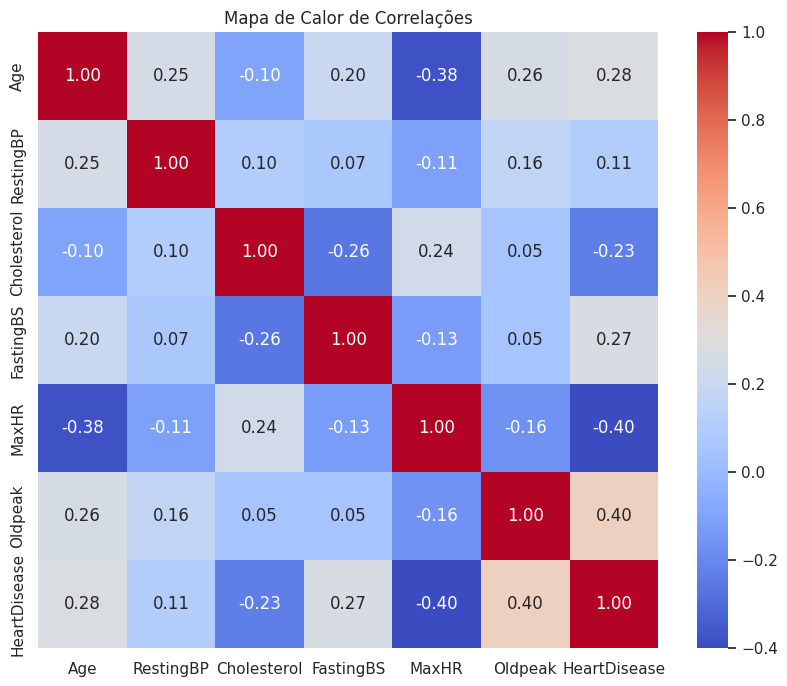

In [99]:
#Mapa de correlações
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Mapa de Calor de Correlações")
plt.show()

In [100]:
freq_table = pd.crosstab(df['ChestPainType'], df['HeartDisease'], normalize='index') * 100
print(freq_table.round(2))

HeartDisease      0     1
ChestPainType            
ASY           20.97 79.03
ATA           86.13 13.87
NAP           64.53 35.47
TA            56.52 43.48


In [101]:
cat_vars = ['Sex', 'ChestPainType', 'ST_Slope', 'RestingECG', 'ExerciseAngina', 'FastingBS']

for var in cat_vars:
    tabela = pd.crosstab(df[var], df['HeartDisease'])
    stat, p, dof, expected = chi2_contingency(tabela)
    print(f"\n Variável: {var}")
    print(f"Estatística Qui-quadrado: {stat:.2f}")
    print(f"p-valor: {p:.4f}")
    if p < 0.05:
        print("Associação significativa com Doença Cardíaca")
    else:
        print("Sem associação significativa")


 Variável: Sex
Estatística Qui-quadrado: 84.15
p-valor: 0.0000
Associação significativa com Doença Cardíaca

 Variável: ChestPainType
Estatística Qui-quadrado: 268.07
p-valor: 0.0000
Associação significativa com Doença Cardíaca

 Variável: ST_Slope
Estatística Qui-quadrado: 355.92
p-valor: 0.0000
Associação significativa com Doença Cardíaca

 Variável: RestingECG
Estatística Qui-quadrado: 10.93
p-valor: 0.0042
Associação significativa com Doença Cardíaca

 Variável: ExerciseAngina
Estatística Qui-quadrado: 222.26
p-valor: 0.0000
Associação significativa com Doença Cardíaca

 Variável: FastingBS
Estatística Qui-quadrado: 64.32
p-valor: 0.0000
Associação significativa com Doença Cardíaca


In [102]:
num_vars = ['Age', 'Cholesterol', 'MaxHR', 'Oldpeak', 'RestingBP']

for var in num_vars:
    doente = df[df['HeartDisease'] == 1][var]
    saudavel = df[df['HeartDisease'] == 0][var]
    stat, p = ttest_ind(doente, saudavel, nan_policy='omit')
    print(f"\n Variável: {var}")
    print(f"Estatística t: {stat:.2f}")
    print(f"p-valor: {p:.4f}")
    if p < 0.05:
        print("Diferença significativa entre os grupos")
    else:
        print("Sem diferença significativa entre os grupos")


 Variável: Age
Estatística t: 8.90
p-valor: 0.0000
Diferença significativa entre os grupos

 Variável: Cholesterol
Estatística t: -7.24
p-valor: 0.0000
Diferença significativa entre os grupos

 Variável: MaxHR
Estatística t: -13.23
p-valor: 0.0000
Diferença significativa entre os grupos

 Variável: Oldpeak
Estatística t: 13.36
p-valor: 0.0000
Diferença significativa entre os grupos

 Variável: RestingBP
Estatística t: 3.28
p-valor: 0.0011
Diferença significativa entre os grupos


 Interpretação dos Resultados Estatísticos

 Critério de Significância (nível padrão: α = 0.05)

- **p < 0.05**  
  ➤ Existe **diferença estatisticamente significativa** entre os grupos analisados.  
  ➤ A variável está **associada** com a presença de **doença cardíaca**.

- **p ≥ 0.05**  
  ➤ **Não há evidência estatística suficiente** para afirmar que os grupos são diferentes.  
  ➤ A variável **não apresenta associação significativa** com a presença de **doença cardíaca**.

> O p-valor representa a probabilidade de observarmos os dados (ou algo mais extremo), assumindo que a **hipótese nula** seja verdadeira (ou seja, que não haja associação ou diferença entre os grupos).


In [103]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Codificar variáveis categóricas
X = pd.get_dummies(X, drop_first=True)
X_encoded = pd.get_dummies(X, drop_first=True)
# Treino/teste split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Padronizar variáveis numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [104]:
log_model = LogisticRegression(max_iter=1000)
knn_model = KNeighborsClassifier()
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Treinamento
log_model.fit(X_train_scaled, y_train)
knn_model.fit(X_train_scaled, y_train)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [117]:
log_model = LogisticRegression(max_iter=1000)
knn_model = KNeighborsClassifier()
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Validação Cruzada no conjunto de treino
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Logistic Regression': log_model,
    'KNN': knn_model,
    'XGBoost': xgb_model
}

print("### Validação Cruzada (Treino) ###")
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')
    print(f"{name} - AUC médio CV: {scores.mean():.4f} ± {scores.std():.4f}")

# Treinar os modelos finais com o conjunto de treino completo
for model in models.values():
    model.fit(X_train_scaled, y_train)

print("\n### Avaliação Final (Teste) ###")
for name, model in models.items():
    preds = model.predict(X_test_scaled)
    probas = model.predict_proba(X_test_scaled)[:, 1]

    print(f"\n🔹 {name}")
    print(f"Accuracy:  {accuracy_score(y_test, preds):.3f}")
    print(f"Precision: {precision_score(y_test, preds):.3f}")
    print(f"Recall:    {recall_score(y_test, preds):.3f}")
    print(f"F1 Score:  {f1_score(y_test, preds):.3f}")
    print(f"ROC AUC:   {roc_auc_score(y_test, probas):.3f}")

### Validação Cruzada (Treino) ###
Logistic Regression - AUC médio CV: 0.9226 ± 0.0142
KNN - AUC médio CV: 0.9026 ± 0.0107
XGBoost - AUC médio CV: 0.9127 ± 0.0144

### Avaliação Final (Teste) ###

🔹 Logistic Regression
Accuracy:  0.853
Precision: 0.900
Recall:    0.841
F1 Score:  0.870
ROC AUC:   0.927

🔹 KNN
Accuracy:  0.853
Precision: 0.900
Recall:    0.841
F1 Score:  0.870
ROC AUC:   0.924

🔹 XGBoost
Accuracy:  0.859
Precision: 0.901
Recall:    0.850
F1 Score:  0.875
ROC AUC:   0.923


# Comparação de Modelos Preditivos para Diagnóstico de Doença Cardíaca

Foram avaliados três modelos de classificação para prever a presença de doença cardíaca, utilizando métricas de desempenho comuns em aprendizado de máquina. Além da avaliação final no conjunto de teste, foi realizada uma validação cruzada no conjunto de treino para garantir a robustez dos resultados.

---

# Validação Cruzada (Treino)

| Modelo              | AUC médio CV | Desvio Padrão CV |
|---------------------|--------------|------------------|
| Logistic Regression  | 0.9226       | ± 0.0142         |
| KNN                 | 0.9026       | ± 0.0107         |
| XGBoost             | 0.9127       | ± 0.0144         |

*Os resultados indicam que a regressão logística teve o melhor desempenho médio e maior estabilidade durante as iterações da validação cruzada.*

---

# Avaliação Final (Teste)

| Modelo              | Accuracy | Precision | Recall | F1 Score | ROC AUC |
|---------------------|----------|-----------|--------|----------|---------|
| Logistic Regression  | 0.853    | 0.900     | 0.841  | 0.870    | 0.927   |
| KNN                 | 0.853    | 0.900     | 0.841  | 0.870    | 0.924   |
| XGBoost             | 0.859    | 0.901     | 0.850  | 0.875    | 0.923   |

---

# **Conclusões**

- **Logistic Regression** apresentou o melhor desempenho médio na validação cruzada (AUC 0.9226), sugerindo boa generalização e estabilidade no treino.
- Na avaliação final, o **XGBoost** obteve a maior acurácia (0.859) e F1 Score (0.875), demonstrando ser o modelo com melhor desempenho prático no conjunto de teste, ainda que por margem pequena.
- Todos os modelos apresentaram **alto ROC AUC (> 0.92)**, indicando excelente capacidade de discriminação entre pacientes com e sem doença cardíaca.
- **Logistic Regression** e **KNN** apresentaram desempenhos muito semelhantes, com ótima precisão e sensibilidade balanceadas, adequados para aplicações clínicas que exigem menor complexidade computacional.


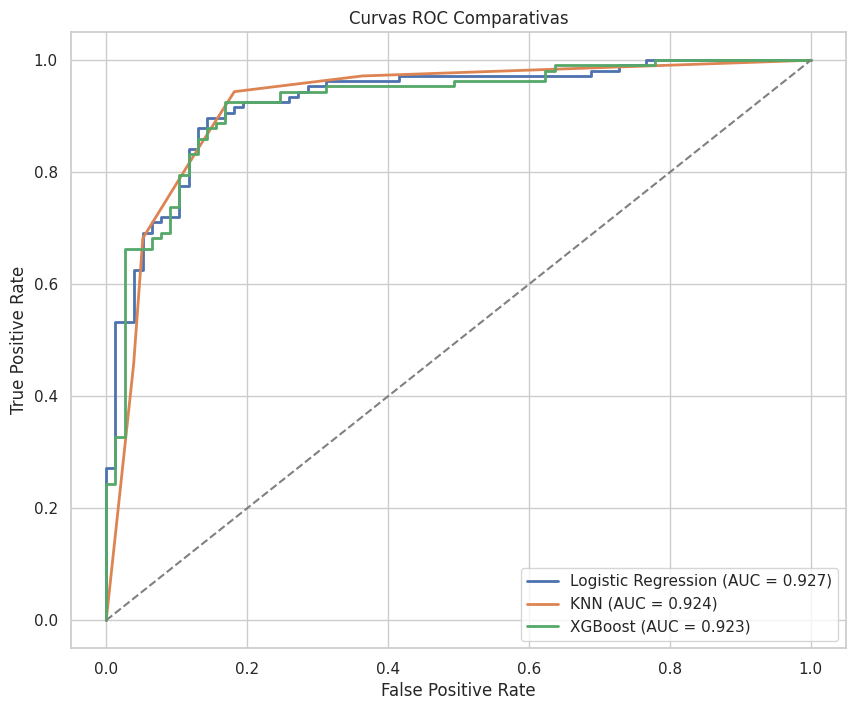

In [106]:
#Curva ROC dos modelos
models = {
    'Logistic Regression': log_model,
    'KNN': knn_model,
    'XGBoost': xgb_model
}

plt.figure(figsize=(10, 8))

for name, model in models.items():
    if name == 'XGBoost':
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
    else:
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        y_pred = model.predict(X_test_scaled)

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Linha base (aleatório)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC Comparativas')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

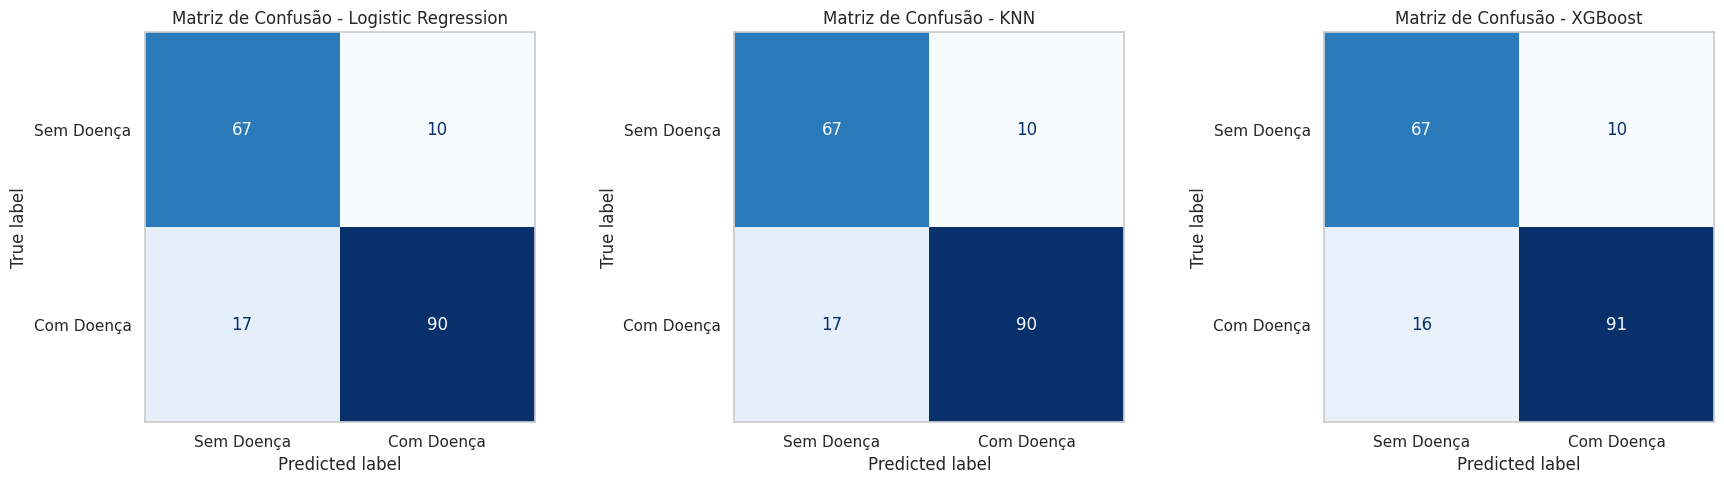

In [107]:
#Matriz de confusão
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model) in zip(axes, models.items()):
    if name == 'XGBoost':
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test_scaled)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sem Doença', 'Com Doença'])
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f'Matriz de Confusão - {name}')
    ax.grid(False)

plt.tight_layout()
plt.show()

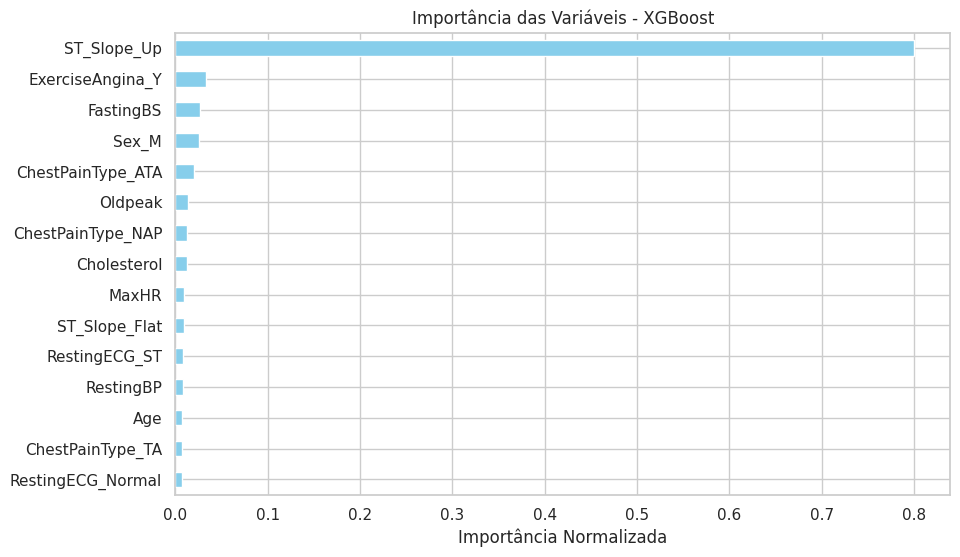

In [108]:
importances = xgb_model.feature_importances_
normalized_importances = importances / importances.sum()

feat_importances = pd.Series(normalized_importances, index=X.columns)

# Gráfico das 15 variáveis mais importantes para o modelo XGBoost na predição da doença cardíaca
plt.figure(figsize=(10, 6))
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='skyblue')
plt.title("Importância das Variáveis - XGBoost")
plt.xlabel("Importância Normalizada")
plt.show()

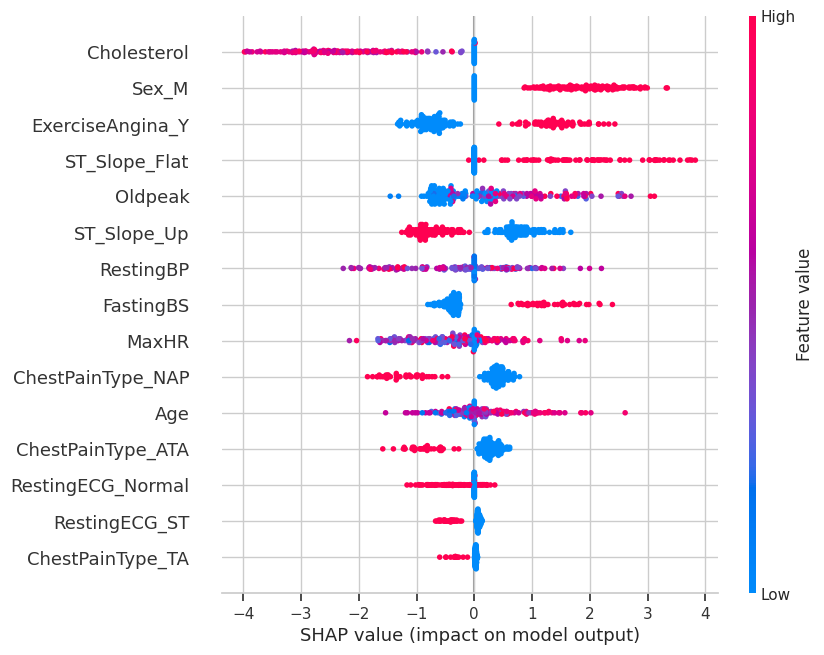

In [109]:
#Sharp
explainer = shap.Explainer(xgb_model, X_test_scaled)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values, max_display=15)

# Resultados com Interpretação SHAP

A análise exploratória revelou diferenças relevantes nas características clínicas entre pacientes sobreviventes e não sobreviventes com falha cardíaca.

O modelo preditivo, com destaque para o XGBoost, apresentou bom desempenho nas métricas avaliadas.

A interpretação pelo SHAP indicou que as variáveis que mais impactaram a predição foram:

- **Colesterol (Cholesterol)**: níveis elevados tiveram grande influência na previsão do modelo.
- **Sexo masculino (Sex_M)**: mostrou-se um importante fator preditivo.
- **Presença de angina induzida por exercício (ExerciseAngina_Y)**: contribuiu significativamente para a decisão do modelo.
- Outras variáveis, como idade, fração de ejeção e pressão arterial sistólica, tiveram impacto menor na interpretação pelo SHAP para este modelo específico.

Esses resultados reforçam a interpretabilidade e a capacidade do modelo em capturar padrões relevantes para o diagnóstico de falha cardíaca, alinhados com as características clínicas analisadas.


# Conclusão

# Conclusão

A análise demonstrou que certos indicadores clínicos, como colesterol, sexo masculino e angina induzida por esforço, têm maior impacto na previsão do risco de falha cardíaca, segundo a explicabilidade fornecida pelo SHAP. Ainda que variáveis tradicionalmente importantes como idade e fração de ejeção também influenciem as decisões do modelo, sua contribuição foi relativamente menor no modelo final treinado.

Entre os modelos avaliados, o **XGBoost** apresentou o melhor desempenho geral no conjunto de teste (Accuracy = 0.859, F1 Score = 0.875), embora a **Regressão Logística** tenha se destacado na validação cruzada com a maior AUC média (0.9226), indicando maior estabilidade e generalização no treino.

Todos os modelos obtiveram **alta área sob a curva ROC (AUC > 0.92)**, demonstrando boa capacidade discriminativa. Os resultados também mostraram **bom equilíbrio entre sensibilidade e precisão**, o que é essencial em contextos clínicos, onde tanto falsos negativos quanto falsos positivos podem trazer riscos ao paciente.

A interpretação com SHAP reforça a utilidade dessas abordagens preditivas como **ferramentas transparentes de apoio à decisão médica**, possibilitando identificar padrões complexos e auxiliar na **detecção precoce de pacientes com maior risco de falha cardíaca**, contribuindo potencialmente para estratégias de intervenção mais eficazes e personalizadas.
